# Note-2: Single-cell deep mtDNA mutation detection quality control.
---

**Author:** Chen Weng

**Date:** October 27, 2023

## Description

This Jupyter Notebook aims reproduce the major analysis in main Figure 1, Extended Data Fig. 1, 3

## Related Figures
- Main Fig. 1 [Section 6, Section 7]
- Extended Data Fig. 1 [Section 5, Section 6]
- Extended Data Fig. 3 [Section 7, Section 8]



---

# Install redeemR

In [1]:
#devtools::install_github("chenweng1991/redeemR")

Skipping install of 'redeemR' from a github remote, the SHA1 (1625c781) has not changed since last install.
  Use `force = TRUE` to force installation



# Import libraries

In [12]:
library(redeemR)
library(dplyr)
library(ggplot2)
library(openxlsx) 
library(Matrix.utils)
library(SummarizedExperiment)
library(stringr)

# Set path

In [4]:
## set main directory to the reproducibility_pub
Dir="/lab/solexa_weissman/cweng/Projects/MitoTracing_Velocity/SecondaryAnalysis/reproducibility_pub" # Change this to your actual path **/reproducibility_pub

# eUMI collision simulation

## Loading mtDNA fragments

Using mtDNA fragments of **Young1-time point 1 HPC** data as an empirical example to estimate Tn5 cutting preference

In [52]:
RealCuttingSite<-read.table(paste(Dir,"/data/others/DN4_HPC_Mito.uniqmapped.fragment.0.cut.mito.tsv",sep=""))

In [55]:
# Get the pool of possible Tn5 cut fragments
TotalCuttingSites<-c(RealCuttingSite$V2,RealCuttingSite$V3)
TotalCuttingpair<-paste(RealCuttingSite$V2,RealCuttingSite$V3,sep="_")

In [71]:
# Average size of the fragments
average_size<-mean(RealCuttingSite$V3-RealCuttingSite$V2)

## Perform the simulation

In [5]:
# Define the function to perform the fragmentation and calculate eUI colision rate 
# given N mtDNA per cell with the detection efficiency 10%
eUMI_simulate<-function(N,E=0.1,S,times=10){
    ## N is the number of mtDNA per cell
    ## E is the capture efficiency, default is 0.1, that is, each mtDNA 10% of regions are actually captured
    ## S is the size of the fragment
    nn<-as.integer(16569*E/S) # The simulated number of fragment captured for each molecule
    cflcts<-c()
        for(i in 1: times){
            FragmentPool<-c()
            for(i in 1:N){
                FragmentPool<-c(FragmentPool,sample(TotalCuttingpair,nn))
            }
        x<-as.data.frame(table(FragmentPool)) %>% .$Freq
        cflcts<-c(cflcts,length(which(x>1))/length(x))    
    }
    return(cflcts)
}

In [91]:
# Simulate 100 mtDNA to 5000 mtDNA per cell
cflcts.100<-eUMI_simulate(N=100,S=average_size)
cflcts.200<-eUMI_simulate(N=200,S=average_size)
cflcts.500<-eUMI_simulate(N=500,S=average_size)
cflcts.1000<-eUMI_simulate(N=1000,S=average_size)
cflcts.2000<-eUMI_simulate(N=2000,S=average_size)
cflcts.5000<-eUMI_simulate(N=5000,S=average_size)

In [ ]:
# These take time, can be skipped
cflcts.10000<-eUMI_simulate(N=10000,S=average_size)
cflcts.20000<-eUMI_simulate(N=20000,S=average_size)  
cflcts.50000<-eUMI_simulate(N=50000,S=average_size) 

In [97]:
datatoplot<-rbind(data.frame(ConflictRatio=cflcts.100, mtDNA=100),data.frame(ConflictRatio=cflcts.200, mtDNA=200),data.frame(ConflictRatio=cflcts.500, mtDNA=500),
                  data.frame(ConflictRatio=cflcts.1000, mtDNA=1000),data.frame(ConflictRatio=cflcts.2000, mtDNA=2000),data.frame(ConflictRatio=cflcts.5000, mtDNA=5000),
                 data.frame(ConflictRatio=cflcts.10000, mtDNA=10000),data.frame(ConflictRatio=cflcts.20000, mtDNA=20000),data.frame(ConflictRatio=cflcts.50000, mtDNA=50000)) 
datatoplot$mtDNA<-factor(datatoplot$mtDNA,levels=c(100,200,500,1000,2000,5000,10000,20000,50000))

## Extended Data Fig. 1a

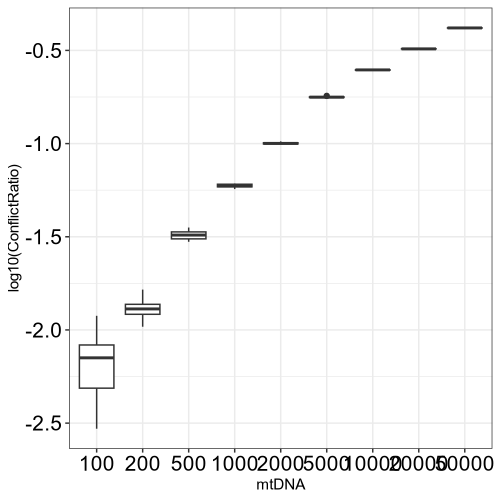

In [100]:
options(repr.plot.width=5, repr.plot.height=5,repr.plot.res=100)
ggplot(datatoplot)+aes(mtDNA,log10(ConflictRatio))+geom_boxplot()+theme_bw()+theme(axis.text = element_text(size=15,color="black"))

## Extended Data Fig. 1b

> This plot was generated by ReDeeM-V [The link to ReDeeM-V tutorial](https://github.com/chenweng1991/redeemV/blob/master/Tutorial_20221025.md)
`Dir/data/redeemV_final/Young1.T1.HPC.Consensus.final/StrandBiase.png`


# Basic QC analysis of ReDeeM consensus mutations

To demonstrate the basic analysis of mitochondrial DNA coverage, mutation filtering,etc, we used **Young1-time point 1 HPC** data as an example 
- `./data/redeemV_final/Young1.T1.HPC.Consensus.final` (Regular ReDeeM protocol and pipeline)
- `./data/redeemV_final/Young1.T1.HPC.NoEnrich.Consensus.final/` (ReDeeM without enrichment, comparable with mtscATAC)

In [ ]:
- 
- 

## Loading data

In [5]:
## Load ReDeeM-V output of Young1 Time point1 HPC 
WD<-paste(Dir,"/data/redeemV_final/Young1.T1.HPC.Consensus.final",sep="")
Young1_HPC.depth<-readRDS(paste(WD,"/DN4_HPC.depth",sep=""))  # DN4 is the internal sample code for Young1,  # this was pre-computed by DepthSummary(WD,CellSubset=NA,only_Total=F)
Young1_HPC.VariantsGTSummary<-CW_mgatk.read(WD,Processed =T) # This is the legacy function, the new function is redeemR.read 
Young1_HPC.Variants.feature.lst<-Vfilter_v3(InputSummary=Young1_HPC.VariantsGTSummary,depth=Young1_HPC.depth) 

CW_mgatk.read is the old version (simultanously reading in all threadhold as a list), it has been deprecated, please use redeemR.read

Vfilter_v3 is the old version that works with CW_mgatk.read , it has been deprecated, please use Vfilter_v4 with redeemR.read



[1] "Total :\n 48151 variants to start"
[1] "48111 variants after remove low quality cells"
 [1] "Tag Homoplasmy: 11674_C_T" "Tag Homoplasmy: 11719_G_A"
 [3] "Tag Homoplasmy: 11947_A_G" "Tag Homoplasmy: 12414_T_C"
 [5] "Tag Homoplasmy: 1243_T_C"  "Tag Homoplasmy: 12705_C_T"
 [7] "Tag Homoplasmy: 12923_G_T" "Tag Homoplasmy: 1406_T_C" 
 [9] "Tag Homoplasmy: 1438_A_G"  "Tag Homoplasmy: 14766_C_T"
[11] "Tag Homoplasmy: 15326_A_G" "Tag Homoplasmy: 15884_G_C"
[13] "Tag Homoplasmy: 16223_C_T" "Tag Homoplasmy: 16292_C_T"
[15] "Tag Homoplasmy: 16519_T_C" "Tag Homoplasmy: 194_C_T"  
[17] "Tag Homoplasmy: 195_T_C"   "Tag Homoplasmy: 199_T_C"  
[19] "Tag Homoplasmy: 204_T_C"   "Tag Homoplasmy: 207_G_A"  
[21] "Tag Homoplasmy: 263_A_G"   "Tag Homoplasmy: 2706_A_G" 
[23] "Tag Homoplasmy: 3505_A_G"  "Tag Homoplasmy: 4769_A_G" 
[25] "Tag Homoplasmy: 5046_G_A"  "Tag Homoplasmy: 5460_G_A" 
[27] "Tag Homoplasmy: 7028_C_T"  "Tag Homoplasmy: 7058_T_C" 
[29] "Tag Homoplasmy: 709_G_A"   "Tag Homoplasmy: 73_A

In [42]:
## Alternatively, run following to create refeemR object only for threadhold S
Young1_HPC_redeemR<-Create_redeemR(redeemR.read(path=WD,thr="S",Processed=F,rdsname = "/new.VariantsGTSummary.RDS")) # This takes several minutes

By default only total depth is summarized

Depprecated 



[1] "Use all cells"
[1] "7404 Cells in QualifiedTotalCts"
[1] "41834 variants to start"
[1] "41735 variants after remove low quality cells"
 [1] "Tag Homoplasmy: 11674_C_T" "Tag Homoplasmy: 11719_G_A"
 [3] "Tag Homoplasmy: 11947_A_G" "Tag Homoplasmy: 12414_T_C"
 [5] "Tag Homoplasmy: 1243_T_C"  "Tag Homoplasmy: 12705_C_T"
 [7] "Tag Homoplasmy: 12923_G_T" "Tag Homoplasmy: 1406_T_C" 
 [9] "Tag Homoplasmy: 1438_A_G"  "Tag Homoplasmy: 14766_C_T"
[11] "Tag Homoplasmy: 15326_A_G" "Tag Homoplasmy: 15884_G_C"
[13] "Tag Homoplasmy: 16223_C_T" "Tag Homoplasmy: 16292_C_T"
[15] "Tag Homoplasmy: 16519_T_C" "Tag Homoplasmy: 194_C_T"  
[17] "Tag Homoplasmy: 195_T_C"   "Tag Homoplasmy: 199_T_C"  
[19] "Tag Homoplasmy: 204_T_C"   "Tag Homoplasmy: 207_G_A"  
[21] "Tag Homoplasmy: 263_A_G"   "Tag Homoplasmy: 2706_A_G" 
[23] "Tag Homoplasmy: 3505_A_G"  "Tag Homoplasmy: 4769_A_G" 
[25] "Tag Homoplasmy: 5046_G_A"  "Tag Homoplasmy: 5460_G_A" 
[27] "Tag Homoplasmy: 7028_C_T"  "Tag Homoplasmy: 7058_T_C" 
[29] "

In [ ]:
## Extended Data Fig. 

## Extended Data Fig. 1c

In [13]:
Young1_HPC_Consensus.raw<-read.table(paste(WD,"/RawGenotypes.Total.StrandBalance",sep=""))
colnames(Young1_HPC_Consensus.raw)<-c("ID","Cell","Pos","Call","Alt","Ref","FamSize","GT_cts","CSS","DB_cts","SG_cts","Strand0","Strand1","TotalQualifyCTS")

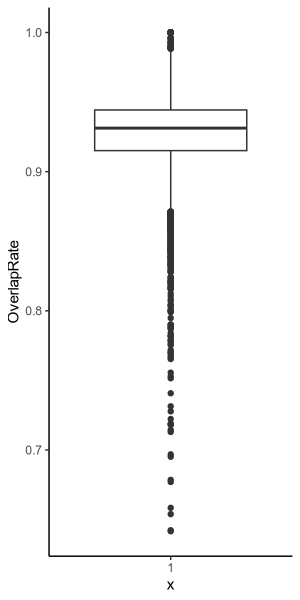

In [7]:
options(repr.plot.width=3, repr.plot.height=6,repr.plot.res=100)
datatoplot<-Young1_HPC_Consensus.raw %>% group_by(Cell) %>% dplyr::summarise(DB=sum(DB_cts),SG=sum(SG_cts)) %>% mutate(OverlapRate=DB/(DB+SG))
ggplot(datatoplot)+aes("1",OverlapRate)+geom_boxplot()+theme_classic()

In [9]:
dim(datatoplot)

[1] 7404    4

## Extended Data Fig 1d

Warning message:
“Removed 1 rows containing non-finite values (`stat_bin()`).”


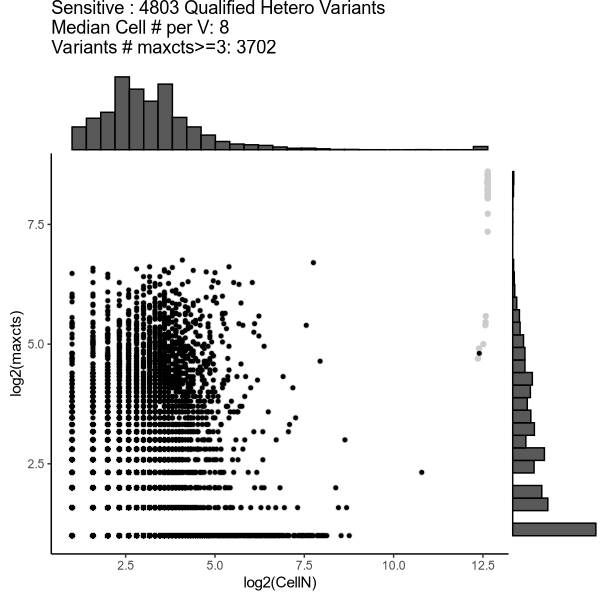

In [45]:
ps<-plot_variant_legacy(Young1_HPC.VariantsGTSummary,Young1_HPC.Variants.feature.lst,depth=Young1_HPC.depth,cat=c("Sensitive"),p4xlim = 30) # This equal to plot_variant(Young1_HPC_redeemR)
options(repr.plot.width=6, repr.plot.height=6,repr.plot.res=100)
ps[[3]]

## Extended Data Fig. 1e,f,g,h

Using Call as id variables



[1] "Quantile of UMI family size"
  0%  25%  50%  75% 100% 
   2    3    5    8  105 
[1] "Quantile of consensus score"
       0%       25%       50%       75%      100% 
0.7575758 1.0000000 1.0000000 1.0000000 1.0000000 
[1] "Percentage of R1/R2 overlaped mutation detections"
[1] 0.9332611


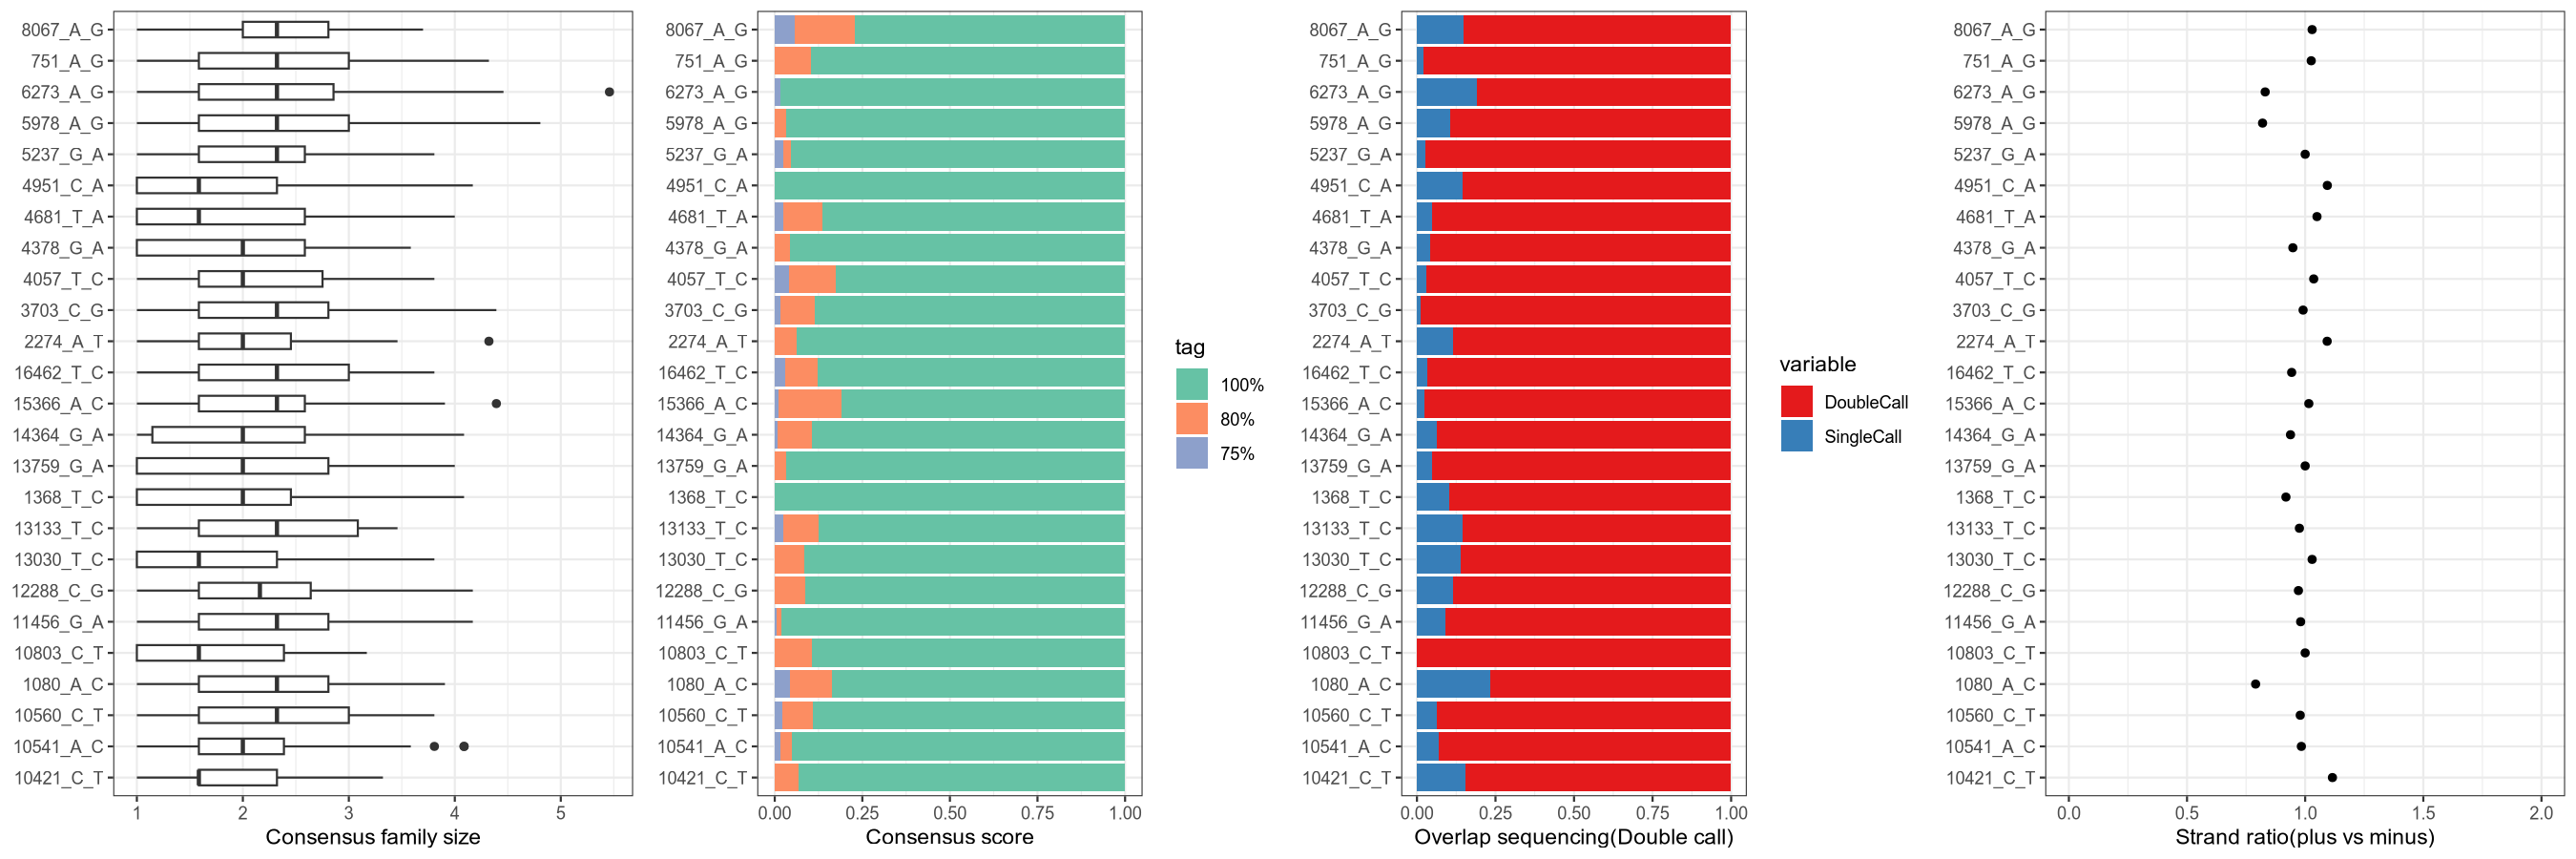

In [47]:
Show_Consensus(Young1_HPC_redeemR)  # It randomly choose mutations to show the consensus benchmark. The exact mutations picked to show are not exactly the same as Extended Data Fig. 2e-h

## Main Fig. 1d top Unfiltered

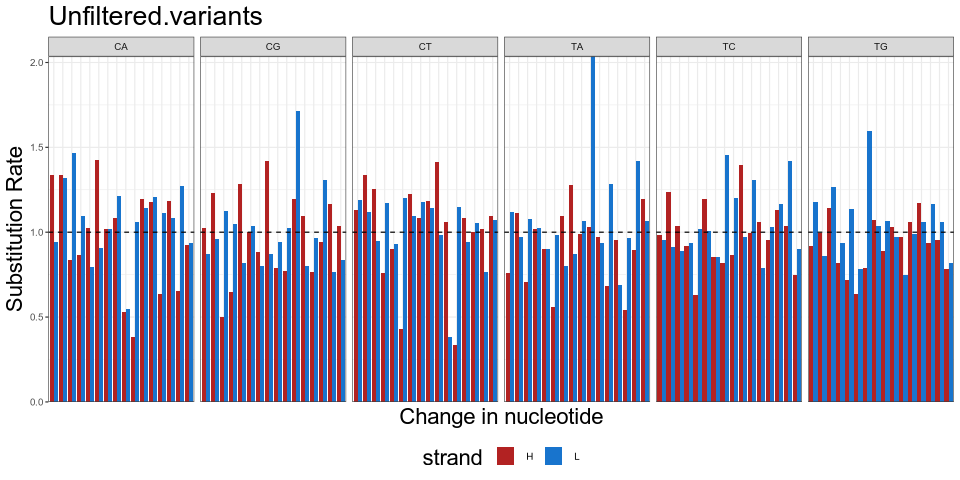

In [115]:
options(repr.plot.width=12, repr.plot.height=6,repr.plot.res=80)
Unfiltered.variants<-unique(Young1_HPC.VariantsGTSummary$Total$Variants)
p<-MutationProfile.bulk(sample(Unfiltered.variants,4837))+ggtitle("Unfiltered.variants")+theme(title =element_text(size=20))
print(p)

## Main Fig. 1d middle After filter

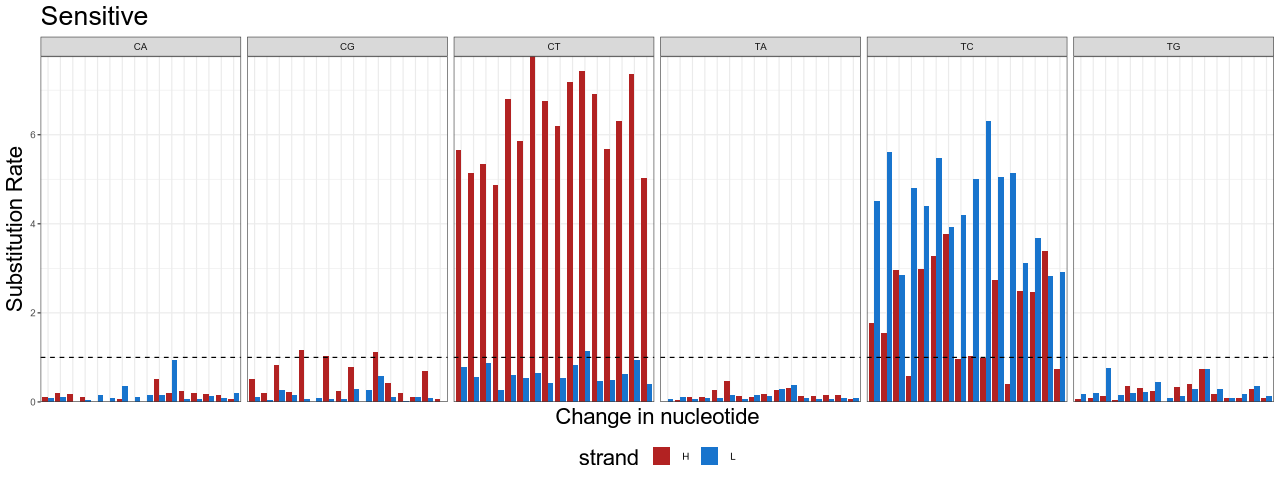

In [111]:
## Plot the mutation signatures
options(repr.plot.width=16, repr.plot.height=6,repr.plot.res=80)
p<-MutationProfile.bulk(Young1_HPC.Variants.feature.lst[["Sensitive"]]$Variants)+ggtitle("Sensitive")+theme(title =element_text(size=20))
print(p)

## Main Fig. 1d bottom Ju et. al, 2014

In [106]:
mito_sig_elife<-read.xlsx(paste(Dir,"/data/mito_sig_elife/elife_02935_supp2_v2.xlsx",sep=""))

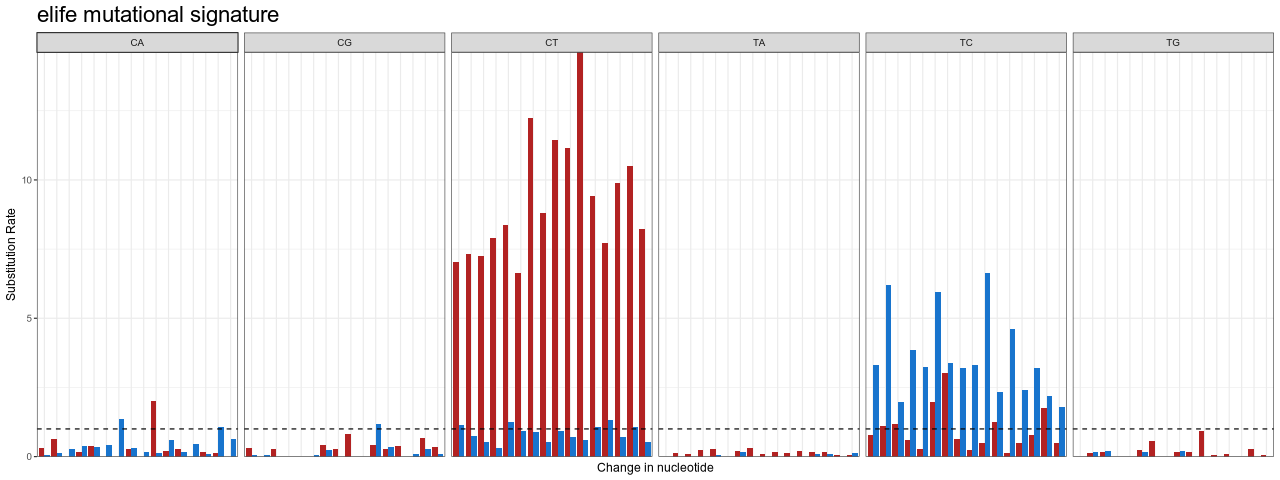

In [112]:
elife_mut<-paste(mito_sig_elife[,3],mito_sig_elife[,4],mito_sig_elife[,5],sep= "_")
options(repr.plot.width=16, repr.plot.height=6,repr.plot.res=80)
MutationProfile.bulk(elife_mut)+ggtitle("elife mutational signature")+theme(legend.position="none",axis.ticks.x = element_blank(),plot.title = element_text(size=20),)

# Compare ReDeeM with mtscATAC

## Loading mtscATAC(no_enrich) ReDeeM

In [7]:
## Load ReDeeM-V output of Young1 Time point1 HPC 
WD<-paste(Dir,"/data/redeemV_final/Young1.T1.HPC.NoEnrich.Consensus.final/",sep="")
mtscATAC.Young1_HPC.depth<-readRDS(paste(WD,"/result_depth.rds",sep=""))  # DN4 is the internal sample code for Young1,  # this was pre-computed by DepthSummary(WD,CellSubset=NA,only_Total=F)
mtscATAC.Young1_HPC.VariantsGTSummary<-CW_mgatk.read(WD,Processed =T) # This is the legacy function, the new function is redeemR.read 
mtscATAC.Young1_HPC.Variants.feature.lst<-Vfilter_v3(InputSummary=mtscATAC.Young1_HPC.VariantsGTSummary,depth=mtscATAC.Young1_HPC.depth) 

CW_mgatk.read is the old version (simultanously reading in all threadhold as a list), it has been deprecated, please use redeemR.read

Vfilter_v3 is the old version that works with CW_mgatk.read , it has been deprecated, please use Vfilter_v4 with redeemR.read



[1] "Total :\n 44823 variants to start"
[1] "43969 variants after remove low quality cells"
 [1] "Tag Homoplasmy: 11674_C_T" "Tag Homoplasmy: 11719_G_A"
 [3] "Tag Homoplasmy: 11947_A_G" "Tag Homoplasmy: 12414_T_C"
 [5] "Tag Homoplasmy: 1243_T_C"  "Tag Homoplasmy: 12705_C_T"
 [7] "Tag Homoplasmy: 12923_G_T" "Tag Homoplasmy: 1406_T_C" 
 [9] "Tag Homoplasmy: 1438_A_G"  "Tag Homoplasmy: 14766_C_T"
[11] "Tag Homoplasmy: 15326_A_G" "Tag Homoplasmy: 15884_G_C"
[13] "Tag Homoplasmy: 16223_C_T" "Tag Homoplasmy: 16292_C_T"
[15] "Tag Homoplasmy: 16519_T_C" "Tag Homoplasmy: 194_C_T"  
[17] "Tag Homoplasmy: 195_T_C"   "Tag Homoplasmy: 199_T_C"  
[19] "Tag Homoplasmy: 204_T_C"   "Tag Homoplasmy: 207_G_A"  
[21] "Tag Homoplasmy: 263_A_G"   "Tag Homoplasmy: 2706_A_G" 
[23] "Tag Homoplasmy: 3505_A_G"  "Tag Homoplasmy: 4769_A_G" 
[25] "Tag Homoplasmy: 5046_G_A"  "Tag Homoplasmy: 5460_G_A" 
[27] "Tag Homoplasmy: 7028_C_T"  "Tag Homoplasmy: 7058_T_C" 
[29] "Tag Homoplasmy: 709_G_A"   "Tag Homoplasmy: 73_A

In [16]:
mtscATAC_Young1_HPC_Consensus.raw<-read.table(paste(WD,"/RawGenotypes.Total.StrandBalance",sep=""))
colnames(mtscATAC_Young1_HPC_Consensus.raw)<-c("ID","Cell","Pos","Call","Alt","Ref","FamSize","GT_cts","CSS","DB_cts","SG_cts","Strand0","Strand1","TotalQualifyCTS")

## Loading mtscATAC(no_enrich) mgatk

In [41]:
Young1_HSPC.mgatk.stats<-read.delim(paste(Dir,"/data/redeemV_final/Young1.T1.HPC.NoEnrich.mgatk.final/final/DN4_HSPC.variant_stats.tsv.gz",sep=""))
Young1_HSPC.cell_heteroplasmic<-read.delim(paste(Dir,"/data/redeemV_final/Young1.T1.HPC.NoEnrich.mgatk.final/final/DN4_HSPC.cell_heteroplasmic_df.tsv.gz",sep=""))

## Extended Data. 3b

In [14]:
# Load the fragment bed file of before enrichment mtscATAC. This is a big file 13.8g
tsv_NoEnch<-read.table(paste(Dir,"/data/others/DN4_HPC_atac_possorted_bam.RawBed.fragment.0.cut.tsv",sep=""))

In [15]:
# Load the fragment bed file of after enrichment ReDeeM. This is a big file 3.8g
tsv_afterEnch<-read.table(paste(Dir,"/data/others/DN4_HPC_Mito.uniqmapped.fragment.0.cut.tsv",sep=""))

In [16]:
# Only useing the reads on cells
library(EZsinglecell2) # devtools::install_github("chenweng1991/EZsinglecell2")
Celltouse<-Young1_HPC.depth$Total[[2]]$V1
Celltouse.RNAname<-gsub("-","",Translate_simple_ATAC2RNA(Celltouse))
tsv_NoEnch_onCell<-subset(tsv_NoEnch,V4 %in% Celltouse.RNAname) %>% mutate(M=ifelse(V1=="chrM",1,0))
tsv_afterEnch_onCell<-subset(tsv_afterEnch, V4 %in% Celltouse) %>% mutate(M=ifelse(V1=="chrM",1,0))


Attaching package: ‘EZsinglecell2’


The following objects are masked from ‘package:redeemR’:

    AddHemSignature, ATAC_Wrapper, DE.gettripple, DoDE, GEM_Wrapper,
    MergeMtx, Motifenrich.binom, Multi_Wrapper, Reclustering,
    Reclustering_hm, Tomerge_v2, Translate_RNA2ATAC,
    Translate_simple_ATAC2RNA, Translate_simple_RNA2ATAC


The following `from` values were not present in `x`: 1, 2, 3



In [17]:
# Summarize the percentage of mito reads
tsv_NoEnch_onCell_Summarise<-tsv_NoEnch_onCell %>% dplyr::group_by(V4) %>% dplyr::summarise(Mpercent=sum(M)/n()) %>% mutate(group="before")
tsv_afterEnch_onCell_Summarise<-tsv_afterEnch_onCell %>% dplyr::group_by(V4) %>% dplyr::summarise(Mpercent=sum(M)/n()) %>% mutate(group="after")
datatoplot<-rbind(tsv_NoEnch_onCell_Summarise,tsv_afterEnch_onCell_Summarise)
datatoplot$group<-factor(datatoplot$group,levels=c("before","after"))

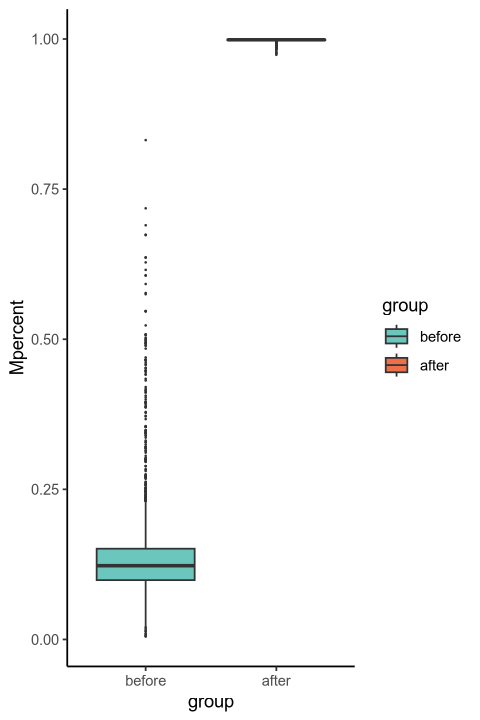

In [18]:
options(repr.plot.width=4, repr.plot.height=6,repr.plot.res=120)
ggplot(datatoplot)+aes(group,Mpercent,fill=group)+geom_boxplot(outlier.size = 0.1)+
scale_fill_manual(values=c("#6BC6BE","#EE704A"))+theme_classic()

In [19]:
dim(datatoplot)

[1] 14808     3

## Extended Data Fig. 3c

In [192]:
## Do comparison before and after enrichment both using scMitoTracing pipeline
scMitoTracing.toplot<-data.frame(Young1_HPC.depth$Total[[1]],group="after") 
scMitoTracing_NoEnch.toplot<-data.frame(mtscATAC.Young1_HPC.depth$Total[[1]],group="before") 
datatoplot<-rbind(scMitoTracing.toplot,scMitoTracing_NoEnch.toplot)

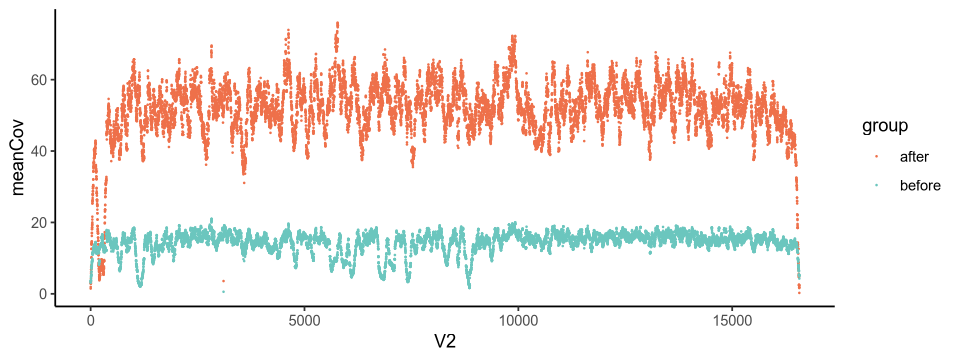

In [194]:
options(repr.plot.width=8, repr.plot.height=3,repr.plot.res=120)
ggplot(datatoplot)+aes(V2,meanCov,color=group)+geom_point(size=0.1)+scale_color_manual(values = c("#EE704A","#6BC6BE"))+theme_classic()

## Extended Data Fig. 3d

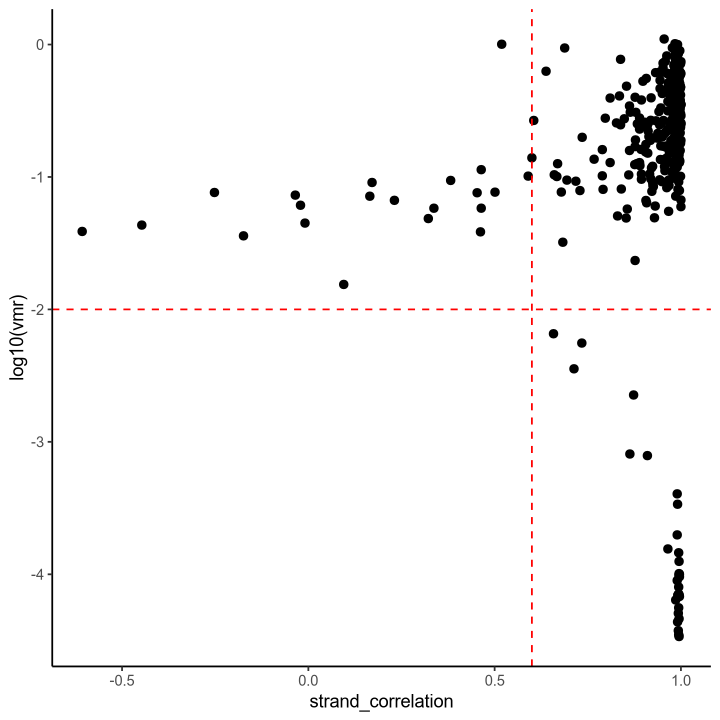

In [125]:
## Make mgatk plot
options(repr.plot.width=6, repr.plot.height=6,repr.plot.res=120)
subset(Young1_HSPC.mgatk.stats,n_cells_conf_detected>=3) %>% ggplot()+aes(strand_correlation,log10(vmr))+geom_point(size=2)+
geom_vline(xintercept = 0.6,color="red",linetype=2)+geom_hline(yintercept = -2,color="red",linetype=2)+theme_classic()

##  Main Fig. 1b

In [199]:
# Compute average family size per cell for regular redeeM
Young1_FamSize_Cell<-Young1_HPC_Consensus.raw %>% group_by(Cell) %>% dplyr::summarise(FamSize.mean=mean(FamSize))
Young1_FamSize_Cell$Cell<-paste(Young1_FamSize_Cell$Cell,"_1",sep="")

In [200]:
# Compute average family size per cell for redeeM without enrichment (mtscATAC)
mtscATAC_Young1_FamSize_Cell<-mtscATAC_Young1_HPC_Consensus.raw %>% group_by(Cell) %>% dplyr::summarise(FamSize.mean=mean(FamSize))
mtscATAC_Young1_FamSize_Cell$Cell<-paste(mtscATAC_Young1_FamSize_Cell$Cell,"_1",sep="")

In [201]:
# Put together both family size and unique coverage
Young1_FamSize_Frag<-Young1_HPC.depth$Total[[2]] %>% mutate(V1=paste(V1,"_1",sep="")) %>% merge(Young1_FamSize_Cell,.,by.x="Cell",by.y="V1")
mtscATAC_Young1_FamSize_Frag<-mtscATAC.Young1_HPC.depth$Total[[2]] %>% mutate(V1=paste(V1,"_1",sep="")) %>% merge(mtscATAC_Young1_FamSize_Cell,.,by.x="Cell",by.y="V1")

In [205]:
# Make datatoplot
datatoplot<-rbind(Young1_FamSize_Frag %>% mutate(group="after"),
     mtscATAC_Young1_FamSize_Frag %>% mutate(group="before"))
datatoplot$group<-factor(datatoplot$group,levels=c("before","after"))

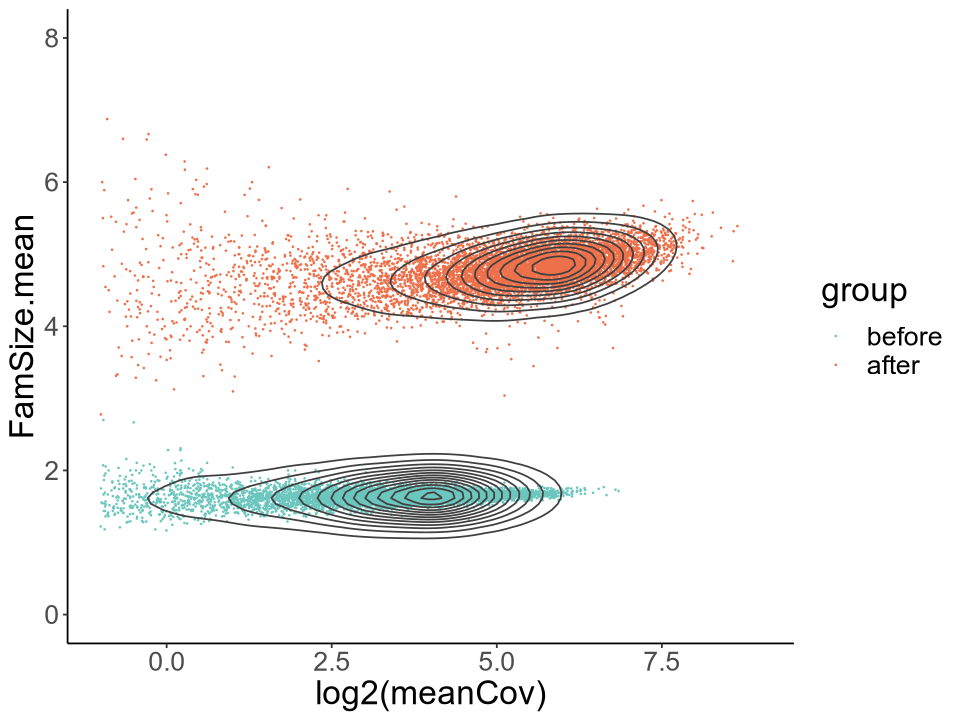

In [207]:
options(repr.plot.width=8, repr.plot.height=6,repr.plot.res=120)
ggplot(datatoplot)+aes(log2(meanCov),FamSize.mean,color=group)+geom_point(size=0.1)+scale_color_manual(values=c("#6BC6BE","#EE704A"))+
geom_density_2d(color=c("grey25"))+theme_classic()+xlim(-1,9)+ylim(0,8)+theme(text=element_text(size=20))

## Main Fig. 1c

In [48]:
# Read in ReDeeMR object (old version)
Young1_HPC_mitoTracing.sensitive<-readRDS(paste(Dir,"/data/redeemR_object_oldversion/DN4_HPC_mitoTracing.sensitive",sep=""))
Young1_HPC_mitoTracing.sensitive<-convert_mitotracing_redeemR(Young1_HPC_mitoTracing.sensitive)

In [47]:
# mgatk identify 311 variants
subset(Young1_HSPC.mgatk.stats,n_cells_conf_detected>=3 &vmr>0.01 & strand_correlation>0.6) %>% dim 

[1] 311  14

In [58]:
Young1_HPC.Variants.feature.lst$Sensitive %>% dim

[1] 4837   10

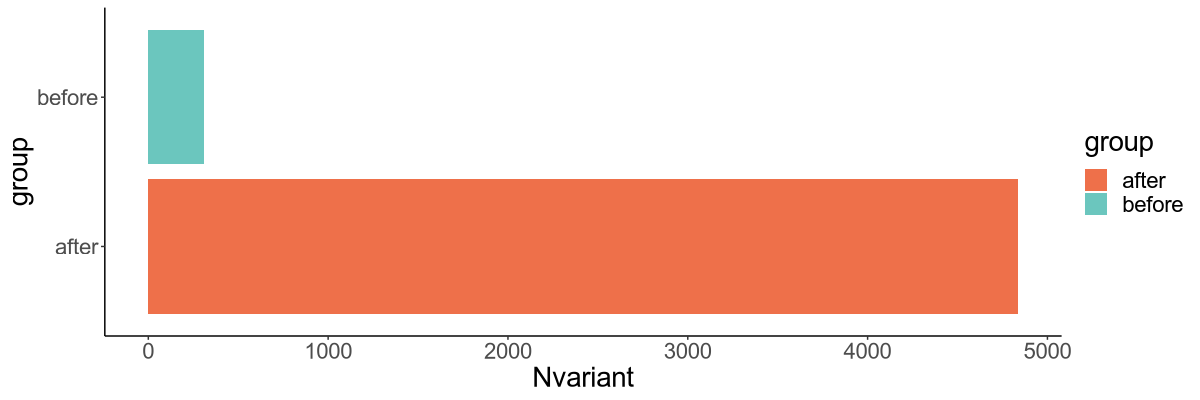

In [63]:
## Plot a simple bar
options(repr.plot.width=12, repr.plot.height=4,repr.plot.res=100)
p<-data.frame(group=c("before","after"),Nvariant=c(311, 4837)) %>% ggplot()+aes(group,Nvariant,fill=group)+geom_bar(stat="identity")+coord_flip()+scale_fill_manual(values=c("#EE704A","#6BC6BE"))+theme_classic()+theme(text=element_text(size=20))
print(p)

## Main Fig. 1e

In [38]:
## Sumarize for regular reDeeM

Young1_HPC_mitoTracing.sensitive@Cts.Mtx.bi<-Young1_HPC_mitoTracing.sensitive@Cts.Mtx.bi[,-match(c("Variants310TC","Variants3109TC"),colnames(Young1_HPC_mitoTracing.sensitive@Cts.Mtx.bi))]  # Remove the two highly abundant variants
VN.summarise.1<-rowSums(Young1_HPC_mitoTracing.sensitive@Cts.Mtx.bi) %>% data.frame(N=.,group="scMitoTracing")
## Filter low coverage cells
BadCells<-subset(Young1_HPC_mitoTracing.sensitive@CellMeta,meanCov<20)$Cell
VN.summarise.1<-VN.summarise.1[!row.names(VN.summarise.1) %in% BadCells,]

In [42]:
## Sumarize for mgatk
Young1_mgatk_Selected_V<-subset(Young1_HSPC.mgatk.stats,strand_correlation>0.6 & vmr>0.01 & n_cells_conf_detected>=3)

Young1_mgatk_Selected_V<-subset(Young1_mgatk_Selected_V,!position %in% c(310,3109))

SelectV.format<-paste("X",gsub(">",".",Young1_mgatk_Selected_V$variant),sep="")
all(SelectV.format %in% colnames(Young1_HSPC.cell_heteroplasmic))

mgatk.selected.mtx<-Young1_HSPC.cell_heteroplasmic[,c("X",SelectV.format)] %>% tibble::column_to_rownames("X")
mgatk.selected.mtx[is.na(mgatk.selected.mtx)]<-0
mgatk.selected.mtx[mgatk.selected.mtx!=0]<-1
VN.summarise.2<-rowSums(mgatk.selected.mtx) %>% data.frame(N=.,group="mgatk")
row.names(VN.summarise.2)<-Translate_simple_RNA2ATAC(row.names(VN.summarise.2))

[1] TRUE

The following `from` values were not present in `x`: 2, 3



In [43]:
# Combine
VN.summarise<-rbind(VN.summarise.1,VN.summarise.2)

Warning message:
“Removed 14 rows containing non-finite values (`stat_bin()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”


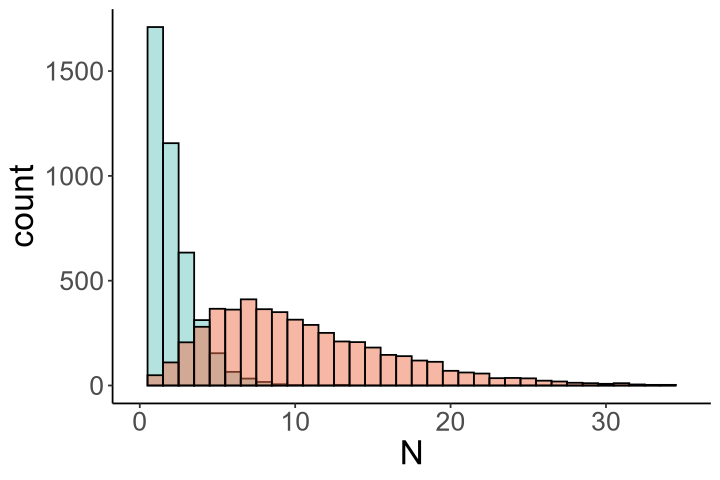

In [64]:
options(repr.plot.width=6, repr.plot.height=4,repr.plot.res=120)
ggplot()+geom_histogram(data=subset(VN.summarise,group=="mgatk"),aes(N),color="black",fill="#6BC6BE",alpha=0.5,binwidth = 1)+
geom_histogram(data=subset(VN.summarise,group=="scMitoTracing"),aes(N),color="black",fill="#EE704A",alpha=0.5,binwidth = 1)+xlim(0,35)+theme_classic()+theme(text=element_text(size=20))

# Comapre ReDeeM with Maester

## Read in MAESTER

In [79]:
## Load function from Peter https://github.com/petervangalen/MAESTER-2021/blob/main/Auxiliary_files/210215_FunctionsGeneral.R
# Function that computes all heteroplasmic variants from MAEGATK output (from Caleb Lareau). Rows represents a position along the mitochondrial genome and the three possible disagreements with the reference (except 3107 has four possible disagreements because the reference is N)
message("computeAFMutMatrix()")
computeAFMutMatrix <- function(SE){

  cov <- assays(SE)[["coverage"]]+ 0.000001
  ref_allele <- as.character(rowRanges(SE)$refAllele)
  
  getMutMatrix <- function(letter){
    mat <- (assays(SE)[[paste0(letter, "_counts_fw")]] + assays(SE)[[paste0(letter, "_counts_rev")]]) / cov
    rownames(mat) <- paste0(as.character(1:dim(mat)[1]), "_", toupper(ref_allele), ">", letter)
    return(mat[toupper(ref_allele) != letter,])
  }
  
  rbind(getMutMatrix("A"), getMutMatrix("C"), getMutMatrix("G"), getMutMatrix("T"))
}

# General
message("cutf()")
cutf <- function(x, f=1, d="/") sapply(strsplit(x, d), function(i) paste(i[f], collapse=d))

computeAFMutMatrix()

cutf()



In [67]:
maegtk<-readRDS(paste(Dir,"/data/maester/Young2_BMMC.maegtk.rds",sep=""))

## Extended Data Fig. 3e

In [68]:
MeanCov<-maegtk@assays@data$coverage %>% rowMeans() %>% data.frame(base=1:16569,meanCov=.)

Warning message:
“Removed 8111 rows containing missing values (`position_stack()`).”
Warning message:
“Removed 3 rows containing missing values (`geom_bar()`).”


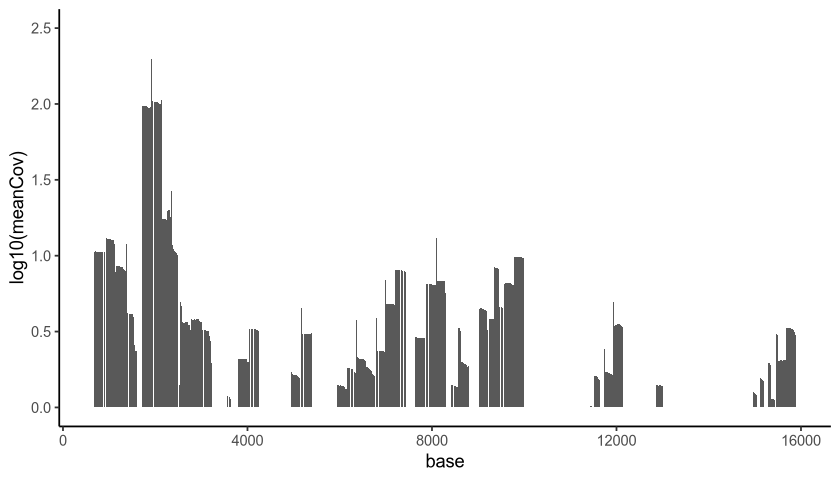

In [70]:
options(repr.plot.width=7, repr.plot.height=4,repr.plot.res=120)
ggplot(MeanCov)+aes(base,log10(meanCov))+geom_bar(stat="identity")+theme_classic()+ylim(0,2.5)

## Processing Young2_BMMC RedeeM

In [106]:
## DN9_BMMC
WD<-"/lab/solexa_weissman/cweng/Projects/MitoTracing_Velocity/SecondaryAnalysis/Donor4Donor9/Donor9/DN9_BMMC/MTenrichCombine/mitoV/final"
Young2_BMMC.depth<-readRDS(paste(WD,"/DN9_BMMC.depth",sep=""))
Young2_BMMC.VariantsGTSummary<-CW_mgatk.read(WD,Processed =T)
Young2_BMMC.Variants.feature.lst<-Vfilter_v3(InputSummary=Young2_BMMC.VariantsGTSummary,depth=Young2_BMMC.depth)


CW_mgatk.read is the old version (simultanously reading in all threadhold as a list), it has been deprecated, please use redeemR.read

Vfilter_v3 is the old version that works with CW_mgatk.read , it has been deprecated, please use Vfilter_v4 with redeemR.read



[1] "Total :\n 48154 variants to start"
[1] "47959 variants after remove low quality cells"
 [1] "Tag Homoplasmy: 1438_A_G"  "Tag Homoplasmy: 15326_A_G"
 [3] "Tag Homoplasmy: 16188_C_G" "Tag Homoplasmy: 16519_T_C"
 [5] "Tag Homoplasmy: 263_A_G"   "Tag Homoplasmy: 3010_G_A" 
 [7] "Tag Homoplasmy: 4769_A_G"  "Tag Homoplasmy: 4859_T_C" 
 [9] "Tag Homoplasmy: 750_A_G"   "Tag Homoplasmy: 8860_A_G" 
[1] "After filtering, 5995 Variants left"
[1] "\n\n"
[1] "VerySensitive :\n 45796 variants to start"
[1] "45398 variants after remove low quality cells"
 [1] "Tag Homoplasmy: 1438_A_G"  "Tag Homoplasmy: 15326_A_G"
 [3] "Tag Homoplasmy: 16188_C_G" "Tag Homoplasmy: 16519_T_C"
 [5] "Tag Homoplasmy: 263_A_G"   "Tag Homoplasmy: 3010_G_A" 
 [7] "Tag Homoplasmy: 4769_A_G"  "Tag Homoplasmy: 4859_T_C" 
 [9] "Tag Homoplasmy: 750_A_G"   "Tag Homoplasmy: 8860_A_G" 
[1] "After filtering, 4670 Variants left"
[1] "\n\n"
[1] "Sensitive :\n 42762 variants to start"
[1] "42188 variants after remove low quality cel

## Extended Data Fig. 3f

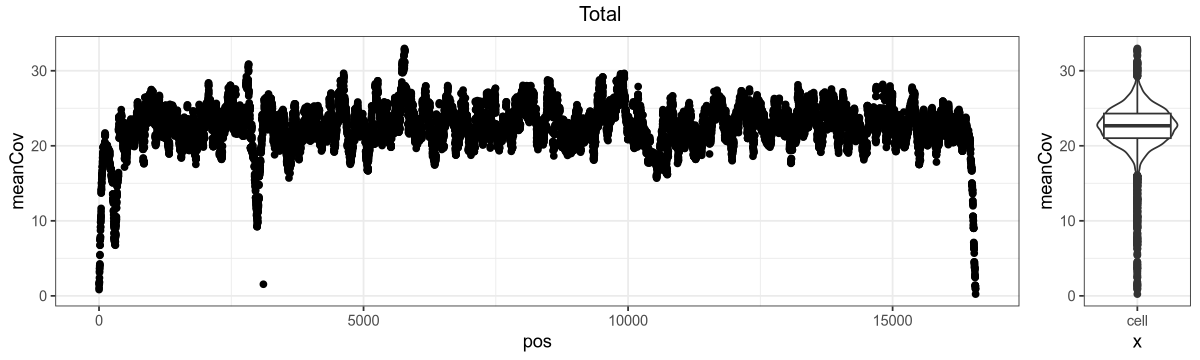

In [112]:
plot_depth_legacy(Young2_BMMC.depth[[1]],"Total")

## Processing MAESTER

In [93]:
af.dm <- suppressWarnings(data.matrix(computeAFMutMatrix(maegtk))*100)

In [95]:
start_time <- Sys.time()
assays.ls <- suppressWarnings(lapply(maegtk@assays@data, function(x) as.matrix(x)))
qual.num <- sapply(rownames(af.dm), function(x) {
    #x <- "2141_T>C"
    pos <- as.numeric( cutf(x, d = "_") )
    mut <- cutf(x, d = ">", f = 2)
    # Get the mean quality of reads for this call (only use cells in which the base was sequenced) - forward
    covered_fw <- assays.ls[[str_c(mut, "_counts_fw")]][pos,] > 0
    qual_fw <- assays.ls[[str_c(mut, "_qual_fw")]][pos, covered_fw]
    # Same for reverse
    covered_rev <- assays.ls[[str_c(mut, "_counts_rev")]][pos,] > 0
    qual_rev <- assays.ls[[str_c(mut, "_qual_rev")]][pos, covered_rev]
    qual <- mean(c(qual_fw, qual_rev))
    return(qual)
})
Sys.time() - start_time

Time difference of 1.603176 mins

In [96]:
# Make tibble
vars.tib <- tibble(var = rownames(af.dm),
                   mean_af = rowMeans(af.dm),
                   mean_cov = rowMeans(assays(maegtk)[["coverage"]])[as.numeric(cutf(rownames(af.dm), d = "_"))],
                   quality = qual.num)

# Calculate the number of cells that exceed VAF thresholds 0, 1, 5, 10, 50 (3 minutes)
start_time <- Sys.time()
vars.tib <- vars.tib %>%
    mutate(n0 = apply(af.dm, 1, function(x) sum(x == 0))) %>%
    mutate(n1 = apply(af.dm, 1, function(x) sum(x > 1))) %>%
    mutate(n5 = apply(af.dm, 1, function(x) sum(x > 5))) %>%
    mutate(n10 = apply(af.dm, 1, function(x) sum(x > 10))) %>%
    mutate(n50 = apply(af.dm, 1, function(x) sum(x > 50)))
Sys.time() - start_time

Time difference of 2.417159 mins

In [92]:
Variant_CellN<-apply(af.dm,1,function(x){length(which(x>0))})
vars.tib<-cbind(vars.tib,Variant_CellN)

In [98]:
vars_filter.tib <- vars.tib %>% filter(mean_cov > 5, quality >= 30, n0 > 0.9*ncol(af.dm),Variant_CellN>=2)

In [101]:
## Apply the same filter as in MAESTER
IsInfo<-function(x){
total<-length(x)
if(length(which(x<10))/total>0.1 & length(which(x>50))>10){
    return("Variable")
}else{
    return("Non")
}
}
Variability<-apply(af.dm,1,IsInfo) %>% data.frame(Info=.)

In [102]:
vars_filter.tib<-Tomerge_v2(vars_filter.tib,Variability) 

## Extended Data Fig. 3g

In [104]:
vars_filter.tib.001<-subset(vars_filter.tib,mean_af>0.01)

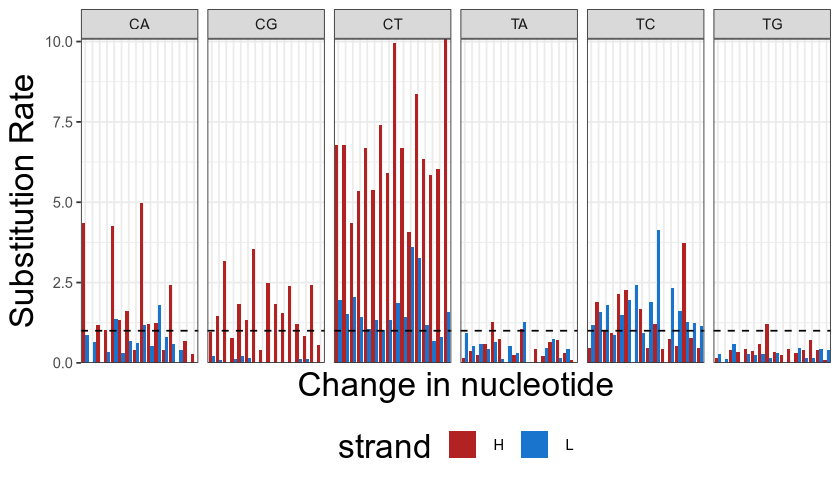

In [105]:
MutationProfile.bulk(gsub(">","_",vars_filter.tib.001$var))+theme(title =element_text(size=20))

## Extended Data Fig. 4h

In [115]:
Young2_BMMC_mitoTracing.sensitive<-readRDS(paste(Dir,"/data/redeemR_object_oldversion/DN9_BMMC_mitoTracing.sensitive",sep=""))

In [124]:
## How many of the 4087 are well covered?
var.tib.f<-vars.tib %>% mutate(var=gsub(">","_",.$var)) 
var.tib.f.4087<-subset(var.tib.f,var %in% Young2_BMMC_mitoTracing.sensitive@V.fitered.list$DN9_BMMC$Variants)

In [127]:
pos<-strsplit(Young2_BMMC_mitoTracing.sensitive@V.fitered.list$DN9_BMMC$Variants,"_") %>% sapply(.,function(x){x[1]}) %>% as.numeric
pos.cov<-Young2_BMMC.depth$Total[[1]][pos,]

In [128]:
## This generate the data frame that combines the maester and mtDNA enrichment, for the Sensitive variants 4087
data<-var.tib.f.4087 %>% mutate(pos=strsplit(.$var,"_") %>% sapply(.,function(x){x[1]}) %>% as.numeric) %>% merge(.,pos.cov,by.x="pos",by.y="V2")

[1] 764
[1] 597


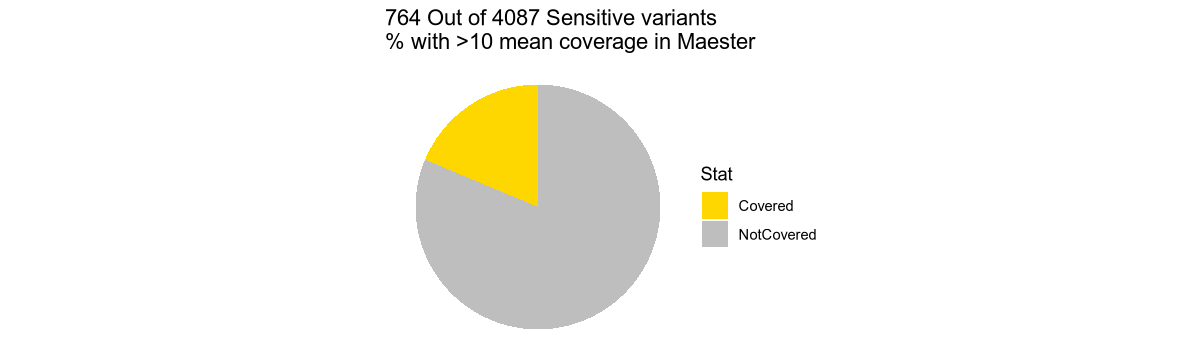

In [129]:
## Plot for 4087 variants
subset(data,mean_cov>5)$n5 %>% length -> A
which(subset(data,mean_cov>5)$n5>1) %>% length ->B
print(A)  # Number of mito mutations that are well covered by Maester
print(B)  # Number of mito mutations that are supported by Maester
data.frame(Stat=c("Covered","NotCovered"),N=c(A,4087-A)) %>% ggplot()+aes("",N,fill=Stat)+geom_bar(stat="identity", width=1)+ coord_polar("y", start=0)+
scale_fill_manual(values=c("gold","grey"))+theme_void()+ggtitle("764 Out of 4087 Sensitive variants\n% with >10 mean coverage in Maester")

[1] 597
[1] 167


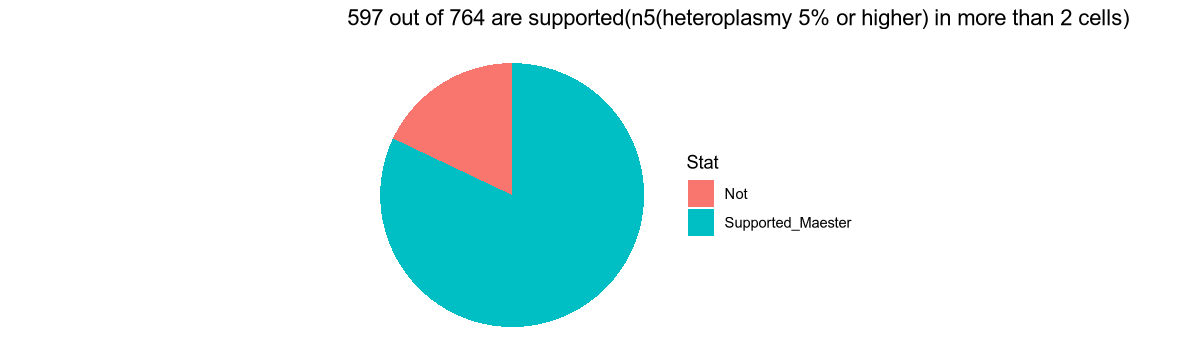

In [130]:
## Support is defined as n5(heteroplasmy 5% or higher) in 2 or more than 2 cells
data.frame(Stat=c("Supported_Maester","Not"),value=c(764,167)) %>% ggplot()+aes("",value,fill=Stat)+geom_bar(stat="identity", width=1)+ coord_polar("y", start=0)+
theme_void()+ggtitle("597 out of 764 are supported(n5(heteroplasmy 5% or higher) in more than 2 cells)")
print(B)
print(A-B)